### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
from pandas.io import gbq
from math import e
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

pd.options.mode.chained_assignment = None  # default='warn'

### Functions for 3rd Pharmacokinetic Model

In [2]:
def create_hep_data(input_df):
    
    output_df = pd.DataFrame(columns=['stay_id','starttime_rate','rate_by_weight'])

    for key, item in input_df.groupby(["stay_id"]):
        item.reset_index(inplace=True, drop=True)

        starttime_rate = []
        rate_by_weight = []

        for i in range(len(item)):
            starttime_rate.append(item.iloc[i,1]) 
            rate_by_weight.append(item.iloc[i,3])

            if i == len(item)-1:
                starttime_rate.append(item.iloc[i,2])

        output_df = output_df.append({
            'stay_id': key,
            'starttime_rate': starttime_rate,
            'rate_by_weight': rate_by_weight},
        ignore_index=True)

    output_df.set_index('stay_id', inplace=True)
    return output_df

def create_ptt_data(input_df):
    
    output_df = pd.DataFrame(columns=['stay_id','rel_charttime'])

    for key, item in input_df.groupby(["stay_id"]):
        item.reset_index(inplace=True, drop=True)

        rel_charttime = []

        for i in range(len(item)):
            rel_charttime.append(item.iloc[i,1]) 

        output_df = output_df.append({
            'stay_id': key,
            'rel_charttime': rel_charttime},
        ignore_index=True)

    output_df.set_index('stay_id', inplace=True)
    return output_df

def insert_data(input_hep,input_ptt):
    
    #Insertions will be made on output_data
    output_data = input_hep
    
    for key, row in input_ptt.iterrows():
    
        for i in range(len(row['rel_charttime'])):

            new_time_entry       = row['rel_charttime'][i]
            new_time_entry_idx   = np.nan
            new_rate_entry       = np.nan
            new_rate_entry_idx   = np.nan

            # Find index in starttime_rate, where new_entry is inserted
            for j in range(len(output_data.loc[key,'starttime_rate'])-1):
                if new_time_entry >= output_data.loc[key,'starttime_rate'][j] and new_time_entry < output_data.loc[key,'starttime_rate'][j+1]:
                    new_time_entry_idx = j+1
                    new_rate_entry_idx = j+1
                    new_rate_entry = output_data.loc[key,'rate_by_weight'][j]
                if j == (len(output_data.loc[key,'starttime_rate'])-2) and new_time_entry > output_data.loc[key,'starttime_rate'][j+1]:
                    new_time_entry_idx = j+2
                    new_rate_entry_idx = j+1
                    new_rate_entry = 0
                    
            if np.isnan(new_time_entry_idx) or np.isnan(new_rate_entry_idx) or np.isnan(new_rate_entry):
                continue
                #print("nan Input")
            else:
                output_data.loc[key,'starttime_rate'].insert(new_time_entry_idx, new_time_entry)
                output_data.loc[key,'rate_by_weight'].insert(new_rate_entry_idx, new_rate_entry)
            
    return output_data

def add_pharmacokinetics_30min(input_df):
    
    output_df = pd.DataFrame(columns=['stay_id','starttime_rate','rate_by_weight','hep_concentration']) 
    
    # Convert Minutes to Hours
    for key, row in input_df.iterrows():
        for i in range(len(row['starttime_rate'])):
            row['starttime_rate'][i] = ((row['starttime_rate'][i])/60).round(decimals=2)

    for key, row in input_df.iterrows():

        hep_concentration = []
        temp_hep = []

        for i in range(len(row['starttime_rate'])):

            if (i == 0):
                hep_concentration.append(0) # At time zero, the concentration is also zero
                temp_hep.append(0)
            else:
                temp_concentration = temp_hep[i-1] + (row['rate_by_weight'][i-1]-temp_hep[i-1])*(1-e**((-2*(row['starttime_rate'][i]-row['starttime_rate'][i-1]))))
                hep_concentration.append(np.around(temp_concentration,decimals=2))
                temp_hep.append(hep_concentration[i])

        output_df = output_df.append({
            'stay_id': key,
            'starttime_rate': row['starttime_rate'],
            'rate_by_weight': row['rate_by_weight'],
            'hep_concentration': hep_concentration},
        ignore_index=True)

    output_df.set_index('stay_id', inplace=True)
    return output_df

def add_pharmacokinetics_45min(input_df):
    
    output_df = pd.DataFrame(columns=['stay_id','starttime_rate','rate_by_weight','hep_concentration']) 
    
    # Convert Minutes to Hours
    for key, row in input_df.iterrows():
        for i in range(len(row['starttime_rate'])):
            row['starttime_rate'][i] = ((row['starttime_rate'][i])/60).round(decimals=2)

    for key, row in input_df.iterrows():

        hep_concentration = []
        temp_hep = []

        for i in range(len(row['starttime_rate'])):

            if (i == 0):
                hep_concentration.append(0) # At time zero, the concentration is also zero
                temp_hep.append(0)
            else:
                temp_concentration = temp_hep[i-1] + (row['rate_by_weight'][i-1]-temp_hep[i-1])*(1-e**((-1.33*(row['starttime_rate'][i]-row['starttime_rate'][i-1]))))
                hep_concentration.append(np.around(temp_concentration,decimals=2))
                temp_hep.append(hep_concentration[i])

        output_df = output_df.append({
            'stay_id': key,
            'starttime_rate': row['starttime_rate'],
            'rate_by_weight': row['rate_by_weight'],
            'hep_concentration': hep_concentration},
        ignore_index=True)

    output_df.set_index('stay_id', inplace=True)
    return output_df

def add_pharmacokinetics_60min(input_df):
    
    output_df = pd.DataFrame(columns=['stay_id','starttime_rate','rate_by_weight','hep_concentration']) 
    
    # Convert Minutes to Hours
    for key, row in input_df.iterrows():
        for i in range(len(row['starttime_rate'])):
            row['starttime_rate'][i] = ((row['starttime_rate'][i])/60).round(decimals=2)

    for key, row in input_df.iterrows():

        hep_concentration = []
        temp_hep = []

        for i in range(len(row['starttime_rate'])):

            if (i == 0):
                hep_concentration.append(0) # At time zero, the concentration is also zero
                temp_hep.append(0)
            else:
                temp_concentration = temp_hep[i-1] + (row['rate_by_weight'][i-1]-temp_hep[i-1])*(1-e**((-1*(row['starttime_rate'][i]-row['starttime_rate'][i-1]))))
                hep_concentration.append(np.around(temp_concentration,decimals=2))
                temp_hep.append(hep_concentration[i])

        output_df = output_df.append({
            'stay_id': key,
            'starttime_rate': row['starttime_rate'],
            'rate_by_weight': row['rate_by_weight'],
            'hep_concentration': hep_concentration},
        ignore_index=True)

    output_df.set_index('stay_id', inplace=True)
    return output_df

def add_pharmacokinetics_120min(input_df):
    
    output_df = pd.DataFrame(columns=['stay_id','starttime_rate','rate_by_weight','hep_concentration']) 
    
    # Convert Minutes to Hours
    for key, row in input_df.iterrows():
        for i in range(len(row['starttime_rate'])):
            row['starttime_rate'][i] = ((row['starttime_rate'][i])/60).round(decimals=2)

    for key, row in input_df.iterrows():

        hep_concentration = []
        temp_hep = []

        for i in range(len(row['starttime_rate'])):

            if (i == 0):
                hep_concentration.append(0) # At time zero, the concentration is also zero
                temp_hep.append(0)
            else:
                temp_concentration = temp_hep[i-1] + (row['rate_by_weight'][i-1]-temp_hep[i-1])*(1-e**((-0.5*(row['starttime_rate'][i]-row['starttime_rate'][i-1]))))
                hep_concentration.append(np.around(temp_concentration,decimals=2))
                temp_hep.append(hep_concentration[i])

        output_df = output_df.append({
            'stay_id': key,
            'starttime_rate': row['starttime_rate'],
            'rate_by_weight': row['rate_by_weight'],
            'hep_concentration': hep_concentration},
        ignore_index=True)

    output_df.set_index('stay_id', inplace=True)
    return output_df

def add_concentration_to_ptt_data(input_df):
    
    query_ptt = """
                SELECT *
                FROM `bachelorarbeit-heparin.mimic_data.cohort1_ptt_data`
                WHERE rel_charttime BETWEEN 0 AND 1440
                """
    df_ptt = gbq.read_gbq(query_ptt, project_id = "bachelorarbeit-heparin")
    
    df_ptt = df_ptt[['stay_id','rel_charttime','PTT']]
    df_ptt['rel_charttime'] = df_ptt['rel_charttime'].div(60).round(2)
    
    final_df = pd.DataFrame(columns=['stay_id','rel_charttime','PTT','rate_by_weight','hep_concentration'])

    for key, item in df_ptt.groupby(["stay_id"]):
        item.reset_index(inplace=True, drop=True)

        for i in range(len(item)):

            idx = np.nan

            for j in range(len(input_df.loc[key,'starttime_rate'])):

                if item.iloc[i,1] == input_df.loc[key,'starttime_rate'][j]:
                    idx = j
                
            final_df = final_df.append({
                'stay_id': key,
                'rel_charttime': item.iloc[i,1],
                'PTT': item.iloc[i,2],
                'rate_by_weight': input_df.loc[key,'rate_by_weight'][idx-1],
                'hep_concentration': input_df.loc[key,'hep_concentration'][idx]
            }, ignore_index=True) 

    final_df = final_df.astype({'stay_id':int})
    final_df.set_index('stay_id', inplace=True)
    
    return(final_df)

### 1st Pharmacokinetic Model - Benchmark

In [9]:
# Load Data
query = """
        SELECT *
        FROM `bachelorarbeit-heparin.mimic_data.cohort1_final`
        """
df = gbq.read_gbq(query, project_id = "bachelorarbeit-heparin")

# Define x & y:
x = pd.DataFrame({'rate_by_weight': df['rate_by_weight']})                 
y = pd.DataFrame({'PTT': df['PTT']})

# Linear Regression & MLP Regressor:
lin_reg_r2_score = []
mlp_reg_r2_score = []

for i in range(100):
    
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=i)
    
    lin_reg = LinearRegression().fit(x_train, y_train)
    lin_reg_r2_score.append(r2_score(y_test, lin_reg.predict(x_test)))
    
    mlp_reg = MLPRegressor(random_state=i, max_iter=500).fit(x_train, y_train.values.ravel())
    mlp_reg_r2_score.append(mlp_reg.score(x_test, y_test))
    
# Polynomial Regression:
max_r2_score = 0
degree = 0

for i in range(2,11, 1):
    
    poly_reg_r2_score = []
    
    for j in range(100):
    
        x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=j)
        poly = PolynomialFeatures(degree=i)
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        lin_reg = LinearRegression().fit(x_train_poly, y_train)
        poly_reg_r2_score.append(r2_score(y_test, lin_reg.predict(x_test_poly)))
        
    if mean(poly_reg_r2_score) > max_r2_score:
        max_r2_score = mean(poly_reg_r2_score)
        degree = i

# Evaluate the Model
print("AVG (n=100) Lin.Reg. R2-Score: ", round(mean(lin_reg_r2_score),4))
print("AVG (n=100) Poly.Reg. R2-Score: ",round(max_r2_score,4)," Degree:",degree)
print("AVG (n=100) MLP Regressor R2-Score: ", round(mean(mlp_reg_r2_score),4))

Downloading: 100%|███████████████████████████████████████████████████████████| 15376/15376 [00:05<00:00, 2874.50rows/s]


AVG (n=100) Lin.Reg. R2-Score:  0.137
AVG (n=100) Poly.Reg. R2-Score:  0.1489  Degree: 9
AVG (n=100) MLP Regressor R2-Score:  0.1366


### 1st Pharmacokinetic Model - Benchmark - Lin.Reg. Example

Downloading: 100%|███████████████████████████████████████████████████████████| 15376/15376 [00:04<00:00, 3341.88rows/s]


EXAMPLE Lin.Reg. R2-Score:  0.1373


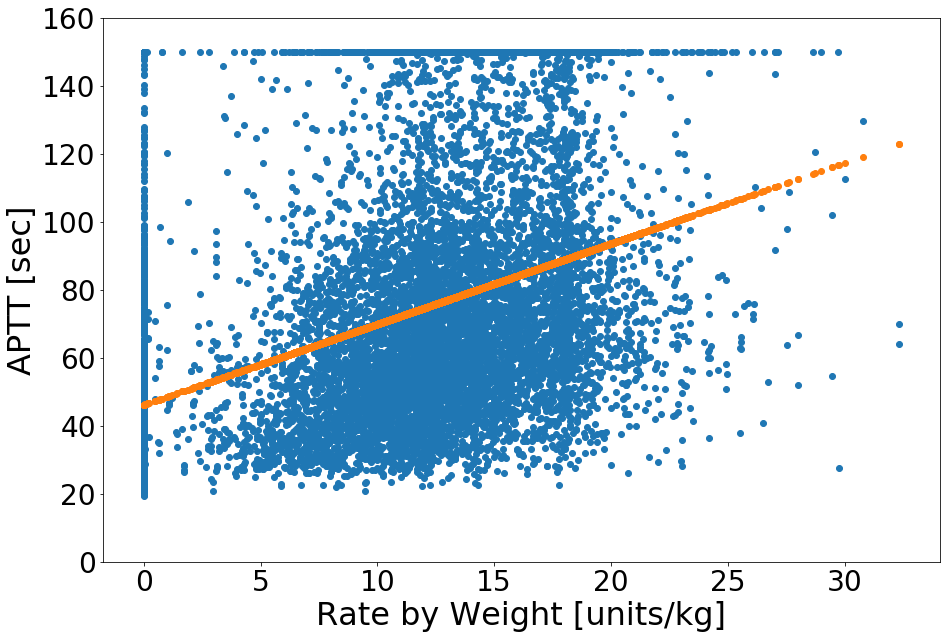

In [11]:
# Load Data
query = """
        SELECT *
        FROM `bachelorarbeit-heparin.mimic_data.cohort1_final`
        """
df = gbq.read_gbq(query, project_id = "bachelorarbeit-heparin")

# Define x & y:
x = pd.DataFrame({'rate_by_weight': df['rate_by_weight']})                 
y = pd.DataFrame({'PTT': df['PTT']})

# Split Data into Train-/Test-Set:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

# Train the Linear Regression Model:
lin_reg = LinearRegression().fit(x_train, y_train)

# Plot the Results:
plt.figure(figsize=(15,10))
plt.xlabel('Rate by Weight [units/kg]', fontsize=32)
plt.ylabel('APTT [sec]', fontsize=32)
plt.ylim(0,160)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.scatter(x_train, y_train)
plt.scatter(x_train, lin_reg.predict(x_train))

# Evaluate the model:
print("EXAMPLE Lin.Reg. R2-Score: ", round(r2_score(y_test, lin_reg.predict(x_test)), 4))

### 1st Pharmacokinetic Model - Benchmark - Poly.Reg. (Degree 9) Example

Downloading: 100%|███████████████████████████████████████████████████████████| 15376/15376 [00:05<00:00, 2809.39rows/s]


EXAMPLE Poly.Reg. (Degree 9) R2-Score:  0.1465


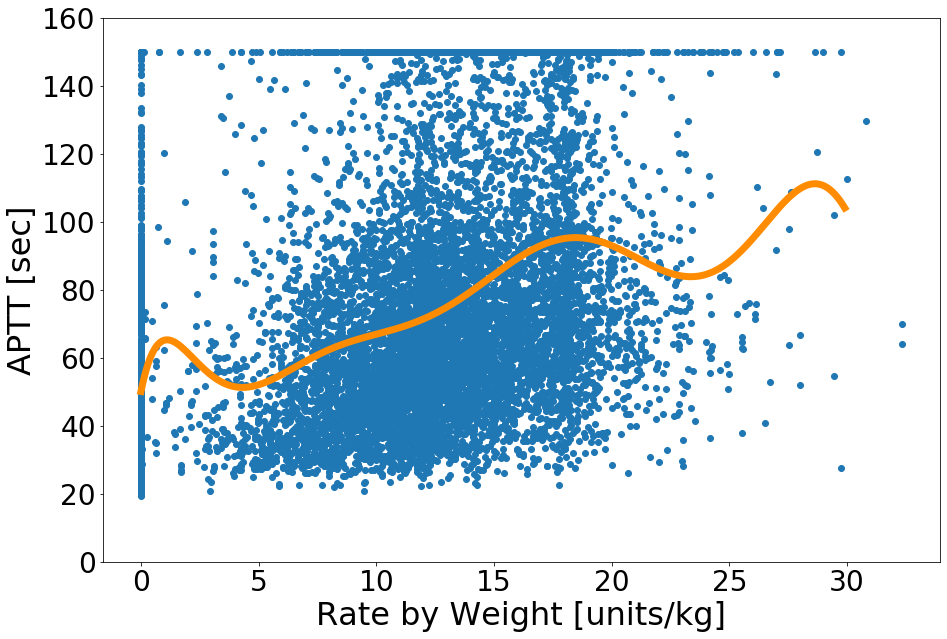

In [3]:
# Load Data
query = """
        SELECT *
        FROM `bachelorarbeit-heparin.mimic_data.cohort1_final`
        """
df = gbq.read_gbq(query, project_id = "bachelorarbeit-heparin")

# Define x & y:
x = pd.DataFrame({'rate_by_weight': df['rate_by_weight']})                 
y = pd.DataFrame({'PTT': df['PTT']})

# Split Data into Train-/Test-Set:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

# Transform to Polynomial Features:
poly = PolynomialFeatures(degree=9)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

# Train the Linear Regression Model:
lin_reg = LinearRegression().fit(x_train_poly, y_train)
coefficient = lin_reg.coef_
intercept = lin_reg.intercept_

# Plot the Results:
x_axis = np.arange(0,30,0.1)
response = intercept + coefficient[0][1] * x_axis + coefficient[0][2] * x_axis**2 + coefficient[0][3] * x_axis**3 + coefficient[0][4] * x_axis**4 + coefficient[0][5] * x_axis**5 + coefficient[0][6] * x_axis**6 + + coefficient[0][7] * x_axis**7 + coefficient[0][8] * x_axis**8 + coefficient[0][9] * x_axis**9

plt.figure(figsize=(15,10))
plt.xlabel('Rate by Weight [units/kg]', fontsize=32)
plt.ylabel('APTT [sec]', fontsize=32)
plt.ylim(0,160)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.scatter(x_train, y_train)
plt.plot(x_axis, response, c='darkorange', linewidth=7)

# Evaluate the model:
print("EXAMPLE Poly.Reg. (Degree 9) R2-Score: ", round(r2_score(y_test, lin_reg.predict(x_test_poly)), 4))

### 1st Pharmacokinetic Model - Benchmark - Modified Dataset

In [16]:
# Load Data
query = """
        SELECT *
        FROM `bachelorarbeit-heparin.mimic_data.cohort1_final`
        WHERE rate_by_weight > 0
        """
df = gbq.read_gbq(query, project_id = "bachelorarbeit-heparin")

# Define x & y:
x = pd.DataFrame({'rate_by_weight': df['rate_by_weight']})                 
y = pd.DataFrame({'PTT': df['PTT']})

# Linear Regression & MLP Regressor:
lin_reg_r2_score = []
mlp_reg_r2_score = []

for i in range(100):
    
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=i)
    
    lin_reg = LinearRegression().fit(x_train, y_train)
    lin_reg_r2_score.append(r2_score(y_test, lin_reg.predict(x_test)))
    
    mlp_reg = MLPRegressor(random_state=i, max_iter=500).fit(x_train, y_train.values.ravel())
    mlp_reg_r2_score.append(mlp_reg.score(x_test, y_test))
    
# Polynomial Regression:
max_r2_score = 0
degree = 0

for i in range(2,11, 1):
    
    poly_reg_r2_score = []
    
    for j in range(100):
    
        x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=j)
        poly = PolynomialFeatures(degree=i)
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        lin_reg = LinearRegression().fit(x_train_poly, y_train)
        poly_reg_r2_score.append(r2_score(y_test, lin_reg.predict(x_test_poly)))
        
    if mean(poly_reg_r2_score) > max_r2_score:
        max_r2_score = mean(poly_reg_r2_score)
        degree = i

# Evaluate the Model
print("AVG (n=100) Lin.Reg. R2-Score: ", round(mean(lin_reg_r2_score),4))
print("AVG (n=100) Poly.Reg. R2-Score: ",round(max_r2_score,4)," Degree:",degree)
print("AVG (n=100) MLP Regressor R2-Score: ", round(mean(mlp_reg_r2_score),4))

Downloading: 100%|███████████████████████████████████████████████████████████| 13519/13519 [00:04<00:00, 3128.65rows/s]


AVG (n=100) Lin.Reg. R2-Score:  0.1022
AVG (n=100) Poly.Reg. R2-Score:  0.112  Degree: 7
AVG (n=100) MLP Regressor R2-Score:  0.1018


### 2nd Pharmacokinetic Model

In [17]:
# Load Data
query = """
        SELECT *
        FROM `bachelorarbeit-heparin.mimic_data.cohort1_final`
        """
df = gbq.read_gbq(query, project_id = "bachelorarbeit-heparin")

# Define x & y:
x = pd.DataFrame({'kum_hep_t': df['kum_hep_t']})                 
y = pd.DataFrame({'PTT': df['PTT']})

# Linear Regression & MLP Regressor:
lin_reg_r2_score = []
mlp_reg_r2_score = []

for i in range(100):
    
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=i)
    
    lin_reg = LinearRegression().fit(x_train, y_train)
    lin_reg_r2_score.append(r2_score(y_test, lin_reg.predict(x_test)))
    
    mlp_reg = MLPRegressor(random_state=i, max_iter=500).fit(x_train, y_train.values.ravel())
    mlp_reg_r2_score.append(mlp_reg.score(x_test, y_test))
    
# Polynomial Regression:
max_r2_score = 0
degree = 0

for i in range(2,11, 1):
    
    poly_reg_r2_score = []
    
    for j in range(100):
    
        x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=j)
        poly = PolynomialFeatures(degree=i)
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        lin_reg = LinearRegression().fit(x_train_poly, y_train)
        poly_reg_r2_score.append(r2_score(y_test, lin_reg.predict(x_test_poly)))
        
    if mean(poly_reg_r2_score) > max_r2_score:
        max_r2_score = mean(poly_reg_r2_score)
        degree = i

# Evaluate the Model
print("AVG (n=100) Lin.Reg. R2-Score: ", round(mean(lin_reg_r2_score),4))
print("AVG (n=100) Poly.Reg. R2-Score: ",round(max_r2_score,4)," Degree:",degree)
print("AVG (n=100) MLP Regressor R2-Score: ", round(mean(mlp_reg_r2_score),4))

Downloading: 100%|███████████████████████████████████████████████████████████| 15376/15376 [00:05<00:00, 3065.99rows/s]


AVG (n=100) Lin.Reg. R2-Score:  0.1749
AVG (n=100) Poly.Reg. R2-Score:  0.185  Degree: 10
AVG (n=100) MLP Regressor R2-Score:  0.1745


In [5]:
# Load Data
query = """
        SELECT *
        FROM `bachelorarbeit-heparin.mimic_data.cohort1_final`
        """
df = gbq.read_gbq(query, project_id = "bachelorarbeit-heparin")

print(df.loc[df['stay_id'] == 30006731])

Downloading: 100%|███████████████████████████████████████████████████████████| 15376/15376 [00:04<00:00, 3352.94rows/s]

       subject_id   hadm_id   stay_id         hadmit_time  rel_charttime  \
14322    19324712  29857283  30006731 2153-10-28 20:38:00            284   
14323    19324712  29857283  30006731 2153-10-28 20:38:00            702   
14324    19324712  29857283  30006731 2153-10-28 20:38:00           1168   

       prev_PTT    PTT  diff_PTT  diff_charttime  sofa_resp  ...  age  gender  \
14322      29.6  138.9     109.3           528.0          0  ...   91       F   
14323     138.9  150.0      11.1           418.0          0  ...   91       F   
14324     150.0   90.2     -59.8           466.0          0  ...   91       F   

       ethnicity                  ICU_Type  rel_starttime  rel_endtime  \
14322      WHITE  Coronary Care Unit (CCU)              0          369   
14323      WHITE  Coronary Care Unit (CCU)            421          830   
14324      WHITE  Coronary Care Unit (CCU)            830         1582   

       rate_by_weight kum_hep_t patientweight ordercategorydescription  


### 2nd Pharmacokinetic Model - Lin.Reg. Example

Downloading: 100%|███████████████████████████████████████████████████████████| 15376/15376 [00:04<00:00, 3200.89rows/s]


EXAMPLE Lin.Reg. R2-Score:  0.188


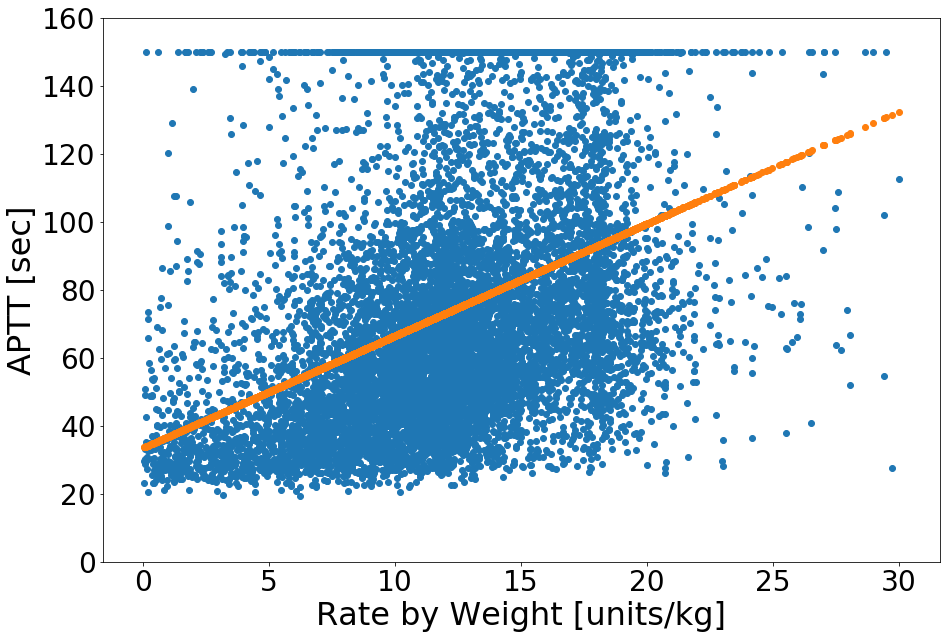

In [21]:
# Load Data
query = """
        SELECT *
        FROM `bachelorarbeit-heparin.mimic_data.cohort1_final`
        """
df = gbq.read_gbq(query, project_id = "bachelorarbeit-heparin")

# Define x & y:
x = pd.DataFrame({'kum_hep_t': df['kum_hep_t']})                 
y = pd.DataFrame({'PTT': df['PTT']})

# Split Data into Train-/Test-Set:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

# Train the Linear Regression Model:
lin_reg = LinearRegression().fit(x_train, y_train)

# Plot the Results:
plt.figure(figsize=(15,10))
plt.xlabel('Rate by Weight [units/kg]', fontsize=32)
plt.ylabel('APTT [sec]', fontsize=32)
plt.ylim(0,160)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.scatter(x_train, y_train)
plt.scatter(x_train, lin_reg.predict(x_train))

# Evaluate the model:
print("EXAMPLE Lin.Reg. R2-Score: ", round(r2_score(y_test, lin_reg.predict(x_test)), 4))

### 2nd Pharmacokinetic Model - Poly.Reg. (Degree 10) Example

Downloading: 100%|███████████████████████████████████████████████████████████| 15376/15376 [00:06<00:00, 2216.71rows/s]


EXAMPLE Poly.Reg. (Degree 10) R2-Score:  0.1945


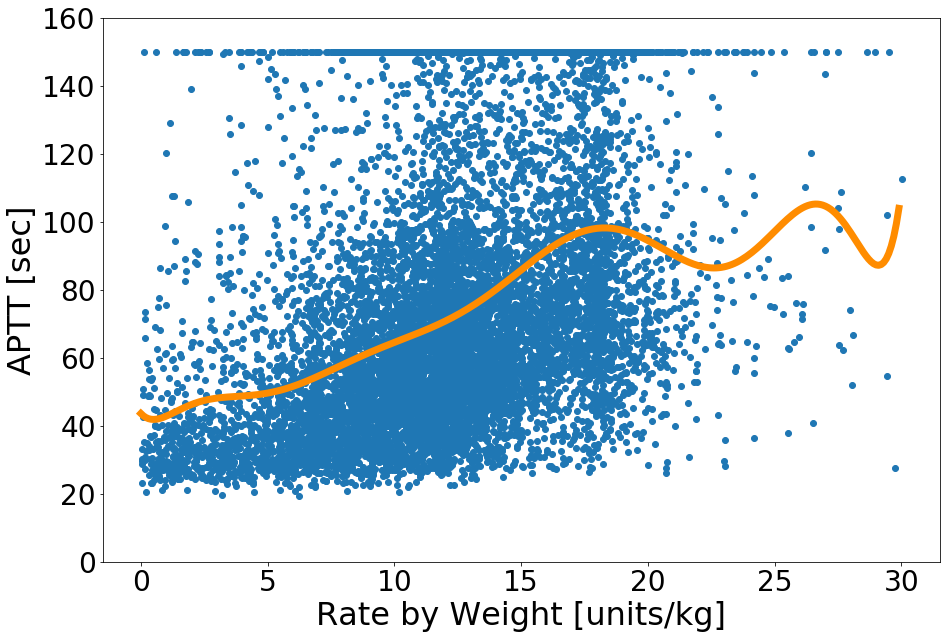

In [7]:
# Load Data
query = """
        SELECT *
        FROM `bachelorarbeit-heparin.mimic_data.cohort1_final`
        """
df = gbq.read_gbq(query, project_id = "bachelorarbeit-heparin")

## Define x & y:
x = pd.DataFrame({'kum_hep_t': df['kum_hep_t']})
y = pd.DataFrame({'PTT': df['PTT']})

# Split Data into Train-/Test-Set:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

# Transform to Polynomial Features:
poly = PolynomialFeatures(degree=10)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

# Train the Linear Regression Model:
lin_reg = LinearRegression()
lin_reg.fit(x_train_poly, y_train)
coefficient = lin_reg.coef_
intercept = lin_reg.intercept_

# Plot the Results:
x_axis = np.arange(0,30,0.1)
response = intercept + coefficient[0][1] * x_axis + coefficient[0][2] * x_axis**2 + coefficient[0][3] * x_axis**3 + coefficient[0][4] * x_axis**4 + coefficient[0][5] * x_axis**5 + coefficient[0][6] * x_axis**6 + + coefficient[0][7] * x_axis**7 + coefficient[0][8] * x_axis**8 + coefficient[0][9] * x_axis**9 + coefficient[0][10] * x_axis**10

# Plot the Results:
plt.figure(figsize=(15,10))
plt.xlabel('Rate by Weight [units/kg]', fontsize=32)
plt.ylabel('APTT [sec]', fontsize=32)
plt.ylim(0,160)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.scatter(x_train, y_train)
plt.plot(x_axis, response, c='darkorange', linewidth=7)

# Evaluate the model:
print("EXAMPLE Poly.Reg. (Degree 10) R2-Score: ", round(r2_score(y_test, lin_reg.predict(x_test_poly)), 4))

### 3rd Pharmacokinetic Model - 30min Half-Life Time

In [5]:
query_hep = """
            SELECT *
            FROM `bachelorarbeit-heparin.mimic_data.cohort1_hep_data_preprocessed`
            ORDER BY subject_id, stay_id, rel_starttime
            """
query_ptt = """
            SELECT *
            FROM `bachelorarbeit-heparin.mimic_data.cohort1_ptt_data`
            WHERE rel_charttime BETWEEN 0 AND 1440
            """
df_hep = gbq.read_gbq(query_hep, project_id = "bachelorarbeit-heparin")
df_ptt = gbq.read_gbq(query_ptt, project_id = "bachelorarbeit-heparin")

df_hep = df_hep[['stay_id','rel_starttime','rel_endtime','rate_by_weight']]
df_hep = df_hep.sort_values(by=['stay_id','rel_starttime'], ascending=True)
df_ptt = df_ptt[['stay_id','rel_charttime','PTT']]
df_ptt = df_ptt.sort_values(by=['stay_id','rel_charttime'], ascending=True)

hep_data = create_hep_data(df_hep)
ptt_data = create_ptt_data(df_ptt)
hep_data = insert_data(hep_data,ptt_data)
complete_df = add_pharmacokinetics_30min(hep_data)
final_df = add_concentration_to_ptt_data(complete_df)

# Define x & y:
x = np.array([final_df['hep_concentration']]).ravel()
y = np.array([final_df['PTT']]).ravel()

# Remove Outliers:
temp = np.empty([])

for i in range(len(x)):
    if x[i] > 200:
        temp = np.append(temp,i) 
        
x = np.delete(x,temp).reshape(-1,1)
y = np.delete(y,temp).reshape(-1,1)

# Linear Regression & MLP Regressor:
lin_reg_r2_score = []
mlp_reg_r2_score = []

for i in range(100):
    
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=i)
    
    lin_reg = LinearRegression().fit(x_train, y_train)
    lin_reg_r2_score.append(r2_score(y_test, lin_reg.predict(x_test)))
    
    mlp_reg = MLPRegressor(random_state=i, max_iter=500).fit(x_train, y_train.ravel())
    mlp_reg_r2_score.append(mlp_reg.score(x_test, y_test))
    
# Polynomial Regression:
max_r2_score = 0
degree = 0

for i in range(2,11, 1):
    
    poly_reg_r2_score = []
    
    for j in range(100):
    
        x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=j)
        poly = PolynomialFeatures(degree=i)
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        lin_reg = LinearRegression().fit(x_train_poly, y_train)
        poly_reg_r2_score.append(r2_score(y_test, lin_reg.predict(x_test_poly)))
        
    if mean(poly_reg_r2_score) > max_r2_score:
        max_r2_score = mean(poly_reg_r2_score)
        degree = i

# Evaluate the Model
print("AVG (n=100) Lin.Reg. R2-Score: ", round(mean(lin_reg_r2_score),4))
print("AVG (n=100) Poly.Reg. R2-Score: ",round(max_r2_score,4)," Degree:",degree)
print("AVG (n=100) MLP Regressor R2-Score: ", round(mean(mlp_reg_r2_score),4))

Downloading: 100%|███████████████████████████████████████████████████████████| 15346/15346 [00:04<00:00, 3642.75rows/s]
C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


AVG (n=100) Lin.Reg. R2-Score:  0.1338
AVG (n=100) Poly.Reg. R2-Score:  0.1483  Degree: 9
AVG (n=100) MLP Regressor R2-Score:  0.1335


### 3rd Pharmacokinetic Model - 30min Half-Life Time - Lin.Reg. Example

C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  if sys.path[0] == '':
C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  del sys.path[0]


EXAMPLE Lin.Reg. R2-Score:  0.1499


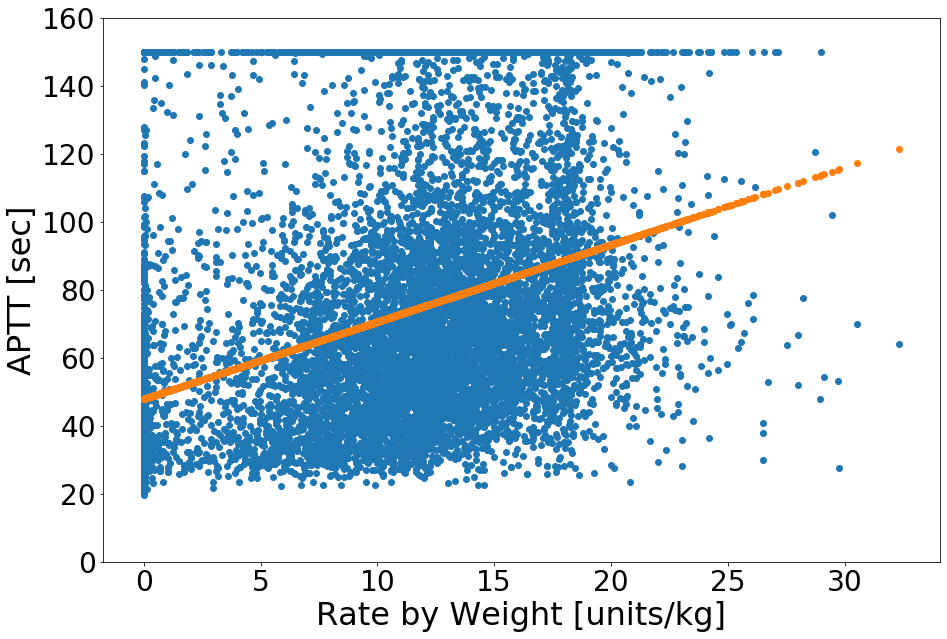

In [4]:
# Define x & y:
x = np.array([final_df['hep_concentration']]).reshape(-1,1)
y = np.array([final_df['PTT']]).reshape(-1,1)

# Remove Outliers:
temp = np.empty([])

for i in range(len(x)):
    if x[i] > 200:
        temp = np.append(temp,i) 
        
x = np.delete(x,temp).reshape(-1,1)
y = np.delete(y,temp).reshape(-1,1)


# Split Data into Train-/Test-Set:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

# Train the Linear Regression Model:
lin_reg = LinearRegression().fit(x_train, y_train)

# Plot the Results:
plt.figure(figsize=(15,10))
plt.xlabel('Rate by Weight [units/kg]', fontsize=32)
plt.ylabel('APTT [sec]', fontsize=32)
plt.ylim(0,160)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.scatter(x_train, y_train)
plt.scatter(x_train, lin_reg.predict(x_train))

# Evaluate the model:
print("EXAMPLE Lin.Reg. R2-Score: ", round(r2_score(y_test, lin_reg.predict(x_test)), 4))

### 3rd Pharmacokinetic Model - 30min Half-Life Time - Poly.Reg. (Degree 9) Example

C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  if sys.path[0] == '':
C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  del sys.path[0]


EXAMPLE Poly.Reg. (Degree 9) R2-Score:  0.1616


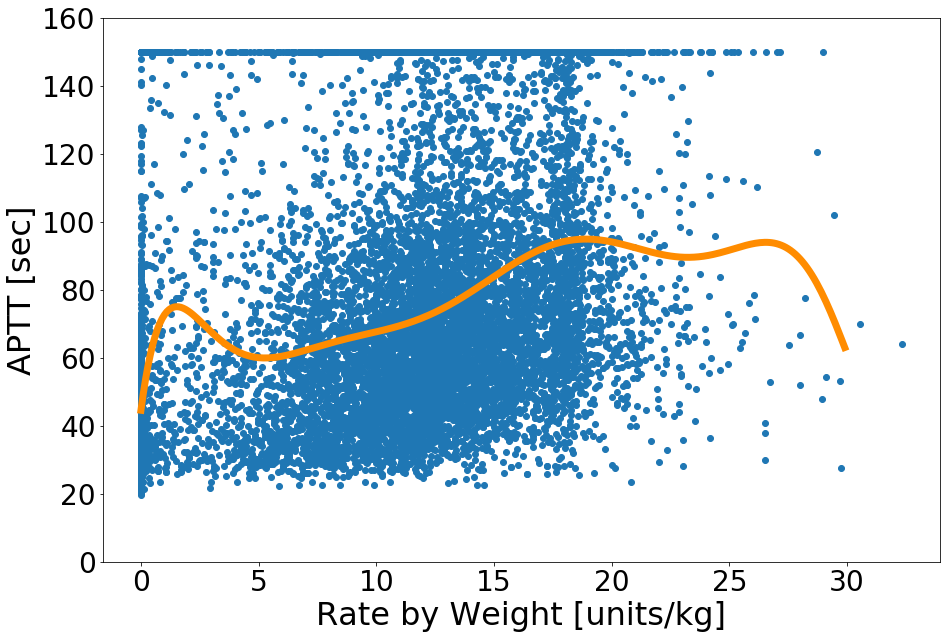

In [6]:
# Define x & y:
x = np.array([final_df['hep_concentration']]).reshape(-1,1)
y = np.array([final_df['PTT']]).reshape(-1,1)

# Remove Outliers:
temp = np.empty([])

for i in range(len(x)):
    if x[i] > 200:
        temp = np.append(temp,i) 
        
x = np.delete(x,temp).reshape(-1,1)
y = np.delete(y,temp).reshape(-1,1)

# Split Data into Train-/Test-Set:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

# Transform to Polynomial Features:
poly = PolynomialFeatures(degree=9)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

# Train the Linear Regression Model:
lin_reg = LinearRegression().fit(x_train_poly, y_train)
coefficient = lin_reg.coef_
intercept = lin_reg.intercept_

# Plot the Results:
x_axis = np.arange(0,30,0.1)
response = intercept + coefficient[0][1] * x_axis + coefficient[0][2] * x_axis**2 + coefficient[0][3] * x_axis**3 + coefficient[0][4] * x_axis**4 + coefficient[0][5] * x_axis**5 + coefficient[0][6] * x_axis**6 + + coefficient[0][7] * x_axis**7 + coefficient[0][8] * x_axis**8 + coefficient[0][9] * x_axis**9

plt.figure(figsize=(15,10))
plt.xlabel('Rate by Weight [units/kg]', fontsize=32)
plt.ylabel('APTT [sec]', fontsize=32)
plt.ylim(0,160)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.scatter(x_train, y_train)
plt.plot(x_axis, response, c='darkorange', linewidth=7)

# Evaluate the model:
print("EXAMPLE Poly.Reg. (Degree 9) R2-Score: ", round(r2_score(y_test, lin_reg.predict(x_test_poly)), 4))

### 3rd Pharmacokinetic Model - 45min Half-Life Time

In [9]:
query_hep = """
            SELECT *
            FROM `bachelorarbeit-heparin.mimic_data.cohort1_hep_data_preprocessed`
            ORDER BY subject_id, stay_id, rel_starttime
            """
query_ptt = """
            SELECT *
            FROM `bachelorarbeit-heparin.mimic_data.cohort1_ptt_data`
            WHERE rel_charttime BETWEEN 0 AND 1440
            """
df_hep = gbq.read_gbq(query_hep, project_id = "bachelorarbeit-heparin")
df_ptt = gbq.read_gbq(query_ptt, project_id = "bachelorarbeit-heparin")

df_hep = df_hep[['stay_id','rel_starttime','rel_endtime','rate_by_weight']]
df_hep = df_hep.sort_values(by=['stay_id','rel_starttime'], ascending=True)
df_ptt = df_ptt[['stay_id','rel_charttime','PTT']]
df_ptt = df_ptt.sort_values(by=['stay_id','rel_charttime'], ascending=True)

hep_data = create_hep_data(df_hep)
ptt_data = create_ptt_data(df_ptt)
hep_data = insert_data(hep_data,ptt_data)
complete_df = add_pharmacokinetics_45min(hep_data)
final_df = add_concentration_to_ptt_data(complete_df)

# Define x & y:
x = np.array([final_df['hep_concentration']]).ravel()
y = np.array([final_df['PTT']]).ravel()

# Remove Outliers:
temp = np.empty([])

for i in range(len(x)):
    if x[i] > 200:
        temp = np.append(temp,i) 
        
x = np.delete(x,temp).reshape(-1,1)
y = np.delete(y,temp).reshape(-1,1)

# Linear Regression & MLP Regressor:
lin_reg_r2_score = []
mlp_reg_r2_score = []

for i in range(100):
    
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=i)
    
    lin_reg = LinearRegression().fit(x_train, y_train)
    lin_reg_r2_score.append(r2_score(y_test, lin_reg.predict(x_test)))
    
    mlp_reg = MLPRegressor(random_state=i, max_iter=500).fit(x_train, y_train.ravel())
    mlp_reg_r2_score.append(mlp_reg.score(x_test, y_test))
    
# Polynomial Regression:
max_r2_score = 0
degree = 0

for i in range(2,11, 1):
    
    poly_reg_r2_score = []
    
    for j in range(100):
    
        x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=j)
        poly = PolynomialFeatures(degree=i)
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        lin_reg = LinearRegression().fit(x_train_poly, y_train)
        poly_reg_r2_score.append(r2_score(y_test, lin_reg.predict(x_test_poly)))
        
    if mean(poly_reg_r2_score) > max_r2_score:
        max_r2_score = mean(poly_reg_r2_score)
        degree = i

# Evaluate the Model
print("AVG (n=100) Lin.Reg. R2-Score: ", round(mean(lin_reg_r2_score),4))
print("AVG (n=100) Poly.Reg. R2-Score: ",round(max_r2_score,4)," Degree:",degree)
print("AVG (n=100) MLP Regressor R2-Score: ", round(mean(mlp_reg_r2_score),4))

Downloading: 100%|███████████████████████████████████████████████████████████| 15346/15346 [00:03<00:00, 3863.22rows/s]
C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


AVG (n=100) Lin.Reg. R2-Score:  0.1302
AVG (n=100) Poly.Reg. R2-Score:  0.1446  Degree: 6
AVG (n=100) MLP Regressor R2-Score:  0.13


### 3rd Pharmacokinetic Model - 45min Half-Life Time - Lin.Reg. Example

C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  if sys.path[0] == '':
C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  del sys.path[0]


EXAMPLE Lin.Reg. R2-Score:  0.1461


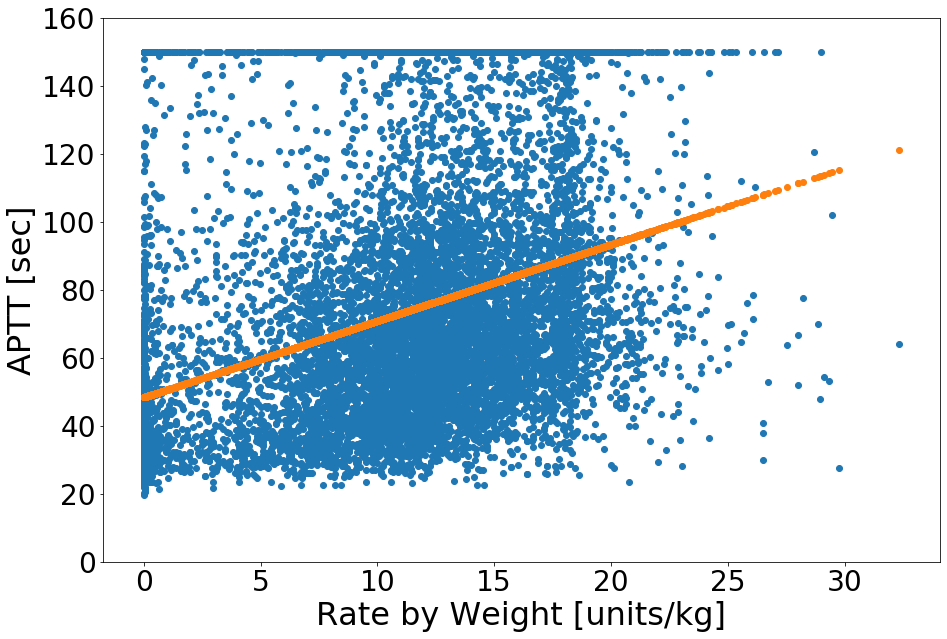

In [10]:
# Define x & y:
x = np.array([final_df['hep_concentration']]).reshape(-1,1)
y = np.array([final_df['PTT']]).reshape(-1,1)

# Remove Outliers:
temp = np.empty([])

for i in range(len(x)):
    if x[i] > 200:
        temp = np.append(temp,i) 
        
x = np.delete(x,temp).reshape(-1,1)
y = np.delete(y,temp).reshape(-1,1)


# Split Data into Train-/Test-Set:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

# Train the Linear Regression Model:
lin_reg = LinearRegression().fit(x_train, y_train)

# Plot the Results:
plt.figure(figsize=(15,10))
plt.xlabel('Rate by Weight [units/kg]', fontsize=32)
plt.ylabel('APTT [sec]', fontsize=32)
plt.ylim(0,160)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.scatter(x_train, y_train)
plt.scatter(x_train, lin_reg.predict(x_train))

# Evaluate the model:
print("EXAMPLE Lin.Reg. R2-Score: ", round(r2_score(y_test, lin_reg.predict(x_test)), 4))

### 3rd Pharmacokinetic Model - 45min Half-Life Time - Poly.Reg. (Degree 6) Example

C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  if sys.path[0] == '':
C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  del sys.path[0]


EXAMPLE Poly.Reg. (Degree 6) R2-Score:  0.1592


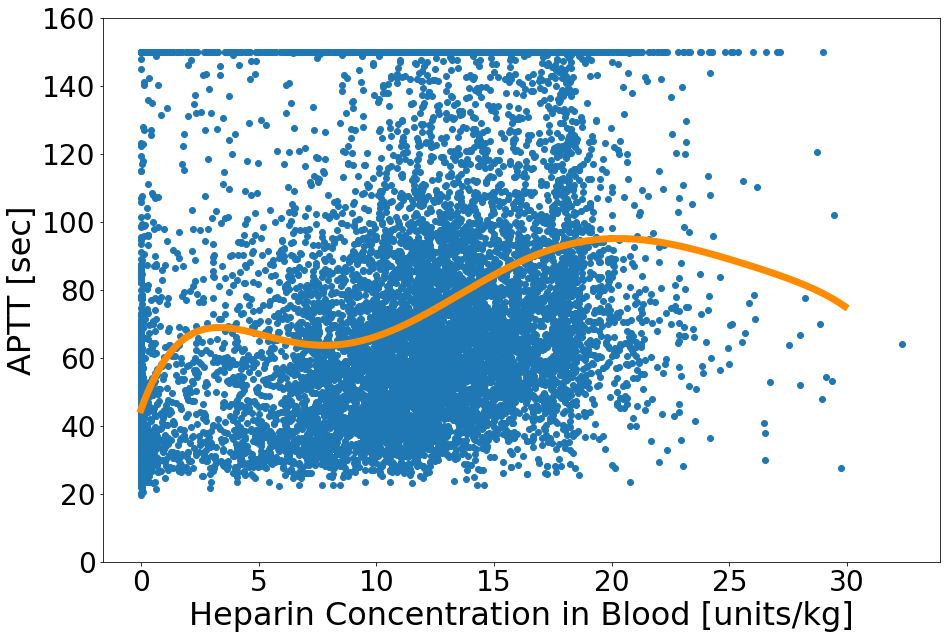

In [11]:
# Define x & y:
x = np.array([final_df['hep_concentration']]).reshape(-1,1)
y = np.array([final_df['PTT']]).reshape(-1,1)

# Remove Outliers:
temp = np.empty([])

for i in range(len(x)):
    if x[i] > 200:
        temp = np.append(temp,i) 
        
x = np.delete(x,temp).reshape(-1,1)
y = np.delete(y,temp).reshape(-1,1)

# Split Data into Train-/Test-Set:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

# Transform to Polynomial Features:
poly = PolynomialFeatures(degree=6)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

# Train the Linear Regression Model:
lin_reg = LinearRegression().fit(x_train_poly, y_train)
coefficient = lin_reg.coef_
intercept = lin_reg.intercept_

# Plot the Results:
x_axis = np.arange(0,30,0.1)
response = intercept + coefficient[0][1] * x_axis + coefficient[0][2] * x_axis**2 + coefficient[0][3] * x_axis**3 + coefficient[0][4] * x_axis**4 + coefficient[0][5] * x_axis**5 + coefficient[0][6] * x_axis**6

plt.figure(figsize=(15,10))
plt.xlabel('Heparin Concentration in Blood [units/kg]', fontsize=32)
plt.ylabel('APTT [sec]', fontsize=32)
plt.ylim(0,160)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.scatter(x_train, y_train)
plt.plot(x_axis, response, c='darkorange', linewidth=7)

# Evaluate the model:
print("EXAMPLE Poly.Reg. (Degree 6) R2-Score: ", round(r2_score(y_test, lin_reg.predict(x_test_poly)), 4))

### 3rd Pharmacokinetic Model - 60min Half-Life Time

In [12]:
query_hep = """
            SELECT *
            FROM `bachelorarbeit-heparin.mimic_data.cohort1_hep_data_preprocessed`
            ORDER BY subject_id, stay_id, rel_starttime
            """
query_ptt = """
            SELECT *
            FROM `bachelorarbeit-heparin.mimic_data.cohort1_ptt_data`
            WHERE rel_charttime BETWEEN 0 AND 1440
            """
df_hep = gbq.read_gbq(query_hep, project_id = "bachelorarbeit-heparin")
df_ptt = gbq.read_gbq(query_ptt, project_id = "bachelorarbeit-heparin")

df_hep = df_hep[['stay_id','rel_starttime','rel_endtime','rate_by_weight']]
df_hep = df_hep.sort_values(by=['stay_id','rel_starttime'], ascending=True)
df_ptt = df_ptt[['stay_id','rel_charttime','PTT']]
df_ptt = df_ptt.sort_values(by=['stay_id','rel_charttime'], ascending=True)

hep_data = create_hep_data(df_hep)
ptt_data = create_ptt_data(df_ptt)
hep_data = insert_data(hep_data,ptt_data)
complete_df = add_pharmacokinetics_60min(hep_data)
final_df = add_concentration_to_ptt_data(complete_df)

# Define x & y:
x = np.array([final_df['hep_concentration']]).ravel()
y = np.array([final_df['PTT']]).ravel()

# Remove Outliers:
temp = np.empty([])

for i in range(len(x)):
    if x[i] > 200:
        temp = np.append(temp,i) 
        
x = np.delete(x,temp).reshape(-1,1)
y = np.delete(y,temp).reshape(-1,1)

# Linear Regression & MLP Regressor:
lin_reg_r2_score = []
mlp_reg_r2_score = []

for i in range(100):
    
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=i)
    
    lin_reg = LinearRegression().fit(x_train, y_train)
    lin_reg_r2_score.append(r2_score(y_test, lin_reg.predict(x_test)))
    
    mlp_reg = MLPRegressor(random_state=i, max_iter=500).fit(x_train, y_train.ravel())
    mlp_reg_r2_score.append(mlp_reg.score(x_test, y_test))
    
# Polynomial Regression:
max_r2_score = 0
degree = 0

for i in range(2,11, 1):
    
    poly_reg_r2_score = []
    
    for j in range(100):
    
        x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=j)
        poly = PolynomialFeatures(degree=i)
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        lin_reg = LinearRegression().fit(x_train_poly, y_train)
        poly_reg_r2_score.append(r2_score(y_test, lin_reg.predict(x_test_poly)))
        
    if mean(poly_reg_r2_score) > max_r2_score:
        max_r2_score = mean(poly_reg_r2_score)
        degree = i

# Evaluate the Model
print("AVG (n=100) Lin.Reg. R2-Score: ", round(mean(lin_reg_r2_score),4))
print("AVG (n=100) Poly.Reg. R2-Score: ",round(max_r2_score,4)," Degree:",degree)
print("AVG (n=100) MLP Regressor R2-Score: ", round(mean(mlp_reg_r2_score),4))

Downloading: 100%|███████████████████████████████████████████████████████████| 15346/15346 [00:04<00:00, 3578.59rows/s]
C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


AVG (n=100) Lin.Reg. R2-Score:  0.1264
AVG (n=100) Poly.Reg. R2-Score:  0.1401  Degree: 6
AVG (n=100) MLP Regressor R2-Score:  0.1262


### 3rd Pharmacokinetic Model - 60min Half-Life Time - Lin.Reg. Example

C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  if sys.path[0] == '':
C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  del sys.path[0]


EXAMPLE Lin.Reg. R2-Score:  0.142


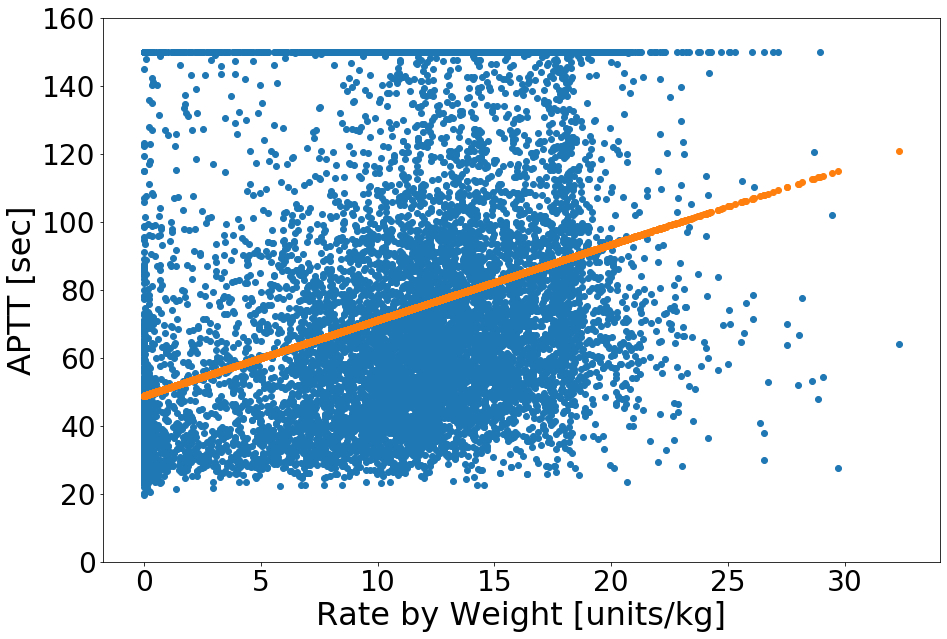

In [13]:
# Define x & y:
x = np.array([final_df['hep_concentration']]).reshape(-1,1)
y = np.array([final_df['PTT']]).reshape(-1,1)

# Remove Outliers:
temp = np.empty([])

for i in range(len(x)):
    if x[i] > 200:
        temp = np.append(temp,i) 
        
x = np.delete(x,temp).reshape(-1,1)
y = np.delete(y,temp).reshape(-1,1)

# Split Data into Train-/Test-Set:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

# Train the Linear Regression Model:
lin_reg = LinearRegression().fit(x_train, y_train)

# Plot the Results:
plt.figure(figsize=(15,10))
plt.xlabel('Rate by Weight [units/kg]', fontsize=32)
plt.ylabel('APTT [sec]', fontsize=32)
plt.ylim(0,160)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.scatter(x_train, y_train)
plt.scatter(x_train, lin_reg.predict(x_train))

# Evaluate the model:
print("EXAMPLE Lin.Reg. R2-Score: ", round(r2_score(y_test, lin_reg.predict(x_test)), 4))

### 3rd Pharmacokinetic Model - 60min Half-Life Time - Poly.Reg. (Degree 6) Example

In [1]:
# Define x & y:
x = np.array([final_df['hep_concentration']]).reshape(-1,1)
y = np.array([final_df['PTT']]).reshape(-1,1)

# Remove Outliers:
temp = np.empty([])

for i in range(len(x)):
    if x[i] > 200:
        temp = np.append(temp,i) 
        
x = np.delete(x,temp).reshape(-1,1)
y = np.delete(y,temp).reshape(-1,1)

# Split Data into Train-/Test-Set:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

# Transform to Polynomial Features:
poly = PolynomialFeatures(degree=6)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

# Train the Linear Regression Model:
lin_reg = LinearRegression().fit(x_train_poly, y_train)
coefficient = lin_reg.coef_
intercept = lin_reg.intercept_

# Plot the Results:
x_axis = np.arange(0,30,0.1)
response = intercept + coefficient[0][1] * x_axis + coefficient[0][2] * x_axis**2 + coefficient[0][3] * x_axis**3 + coefficient[0][4] * x_axis**4 + coefficient[0][5] * x_axis**5 + coefficient[0][6] * x_axis**6

plt.figure(figsize=(15,10))
plt.xlabel('Heparin Concentration in Blood [units/kg]', fontsize=32)
plt.ylabel('APTT [sec]', fontsize=32)
plt.ylim(0,160)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.scatter(x_train, y_train)
plt.plot(x_axis, response, c='darkorange', linewidth=7)

# Evaluate the model:
print("EXAMPLE Poly.Reg. (Degree 6) R2-Score: ", round(r2_score(y_test, lin_reg.predict(x_test_poly)), 4))

NameError: name 'np' is not defined

### 3rd Pharmacokinetic Model - 120min Half-Life Time

In [16]:
query_hep = """
            SELECT *
            FROM `bachelorarbeit-heparin.mimic_data.cohort1_hep_data_preprocessed`
            ORDER BY subject_id, stay_id, rel_starttime
            """
query_ptt = """
            SELECT *
            FROM `bachelorarbeit-heparin.mimic_data.cohort1_ptt_data`
            WHERE rel_charttime BETWEEN 0 AND 1440
            """
df_hep = gbq.read_gbq(query_hep, project_id = "bachelorarbeit-heparin")
df_ptt = gbq.read_gbq(query_ptt, project_id = "bachelorarbeit-heparin")

df_hep = df_hep[['stay_id','rel_starttime','rel_endtime','rate_by_weight']]
df_hep = df_hep.sort_values(by=['stay_id','rel_starttime'], ascending=True)
df_ptt = df_ptt[['stay_id','rel_charttime','PTT']]
df_ptt = df_ptt.sort_values(by=['stay_id','rel_charttime'], ascending=True)

hep_data = create_hep_data(df_hep)
ptt_data = create_ptt_data(df_ptt)
hep_data = insert_data(hep_data,ptt_data)
complete_df = add_pharmacokinetics_120min(hep_data)
final_df = add_concentration_to_ptt_data(complete_df)

# Define x & y:
x = np.array([final_df['hep_concentration']]).ravel()
y = np.array([final_df['PTT']]).ravel()

# Remove Outliers:
temp = np.empty([])

for i in range(len(x)):
    if x[i] > 200:
        temp = np.append(temp,i) 
        
x = np.delete(x,temp).reshape(-1,1)
y = np.delete(y,temp).reshape(-1,1)

# Linear Regression & MLP Regressor:
lin_reg_r2_score = []
mlp_reg_r2_score = []

for i in range(100):
    
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=i)
    
    lin_reg = LinearRegression().fit(x_train, y_train)
    lin_reg_r2_score.append(r2_score(y_test, lin_reg.predict(x_test)))
    
    mlp_reg = MLPRegressor(random_state=i, max_iter=500).fit(x_train, y_train.ravel())
    mlp_reg_r2_score.append(mlp_reg.score(x_test, y_test))
    
# Polynomial Regression:
max_r2_score = 0
degree = 0

for i in range(2,11, 1):
    
    poly_reg_r2_score = []
    
    for j in range(100):
    
        x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=j)
        poly = PolynomialFeatures(degree=i)
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        lin_reg = LinearRegression().fit(x_train_poly, y_train)
        poly_reg_r2_score.append(r2_score(y_test, lin_reg.predict(x_test_poly)))
        
    if mean(poly_reg_r2_score) > max_r2_score:
        max_r2_score = mean(poly_reg_r2_score)
        degree = i

# Evaluate the Model
print("AVG (n=100) Lin.Reg. R2-Score: ", round(mean(lin_reg_r2_score),4))
print("AVG (n=100) Poly.Reg. R2-Score: ",round(max_r2_score,4)," Degree:",degree)
print("AVG (n=100) MLP Regressor R2-Score: ", round(mean(mlp_reg_r2_score),4))

Downloading: 100%|███████████████████████████████████████████████████████████| 15346/15346 [00:04<00:00, 3644.42rows/s]
C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


AVG (n=100) Lin.Reg. R2-Score:  0.0993
AVG (n=100) Poly.Reg. R2-Score:  0.1057  Degree: 2
AVG (n=100) MLP Regressor R2-Score:  0.0917


### 3rd Pharmacokinetic Model - 120min Half-Life Time - Lin.Reg. Example

C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  if sys.path[0] == '':
C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  del sys.path[0]


EXAMPLE Lin.Reg. R2-Score:  0.084


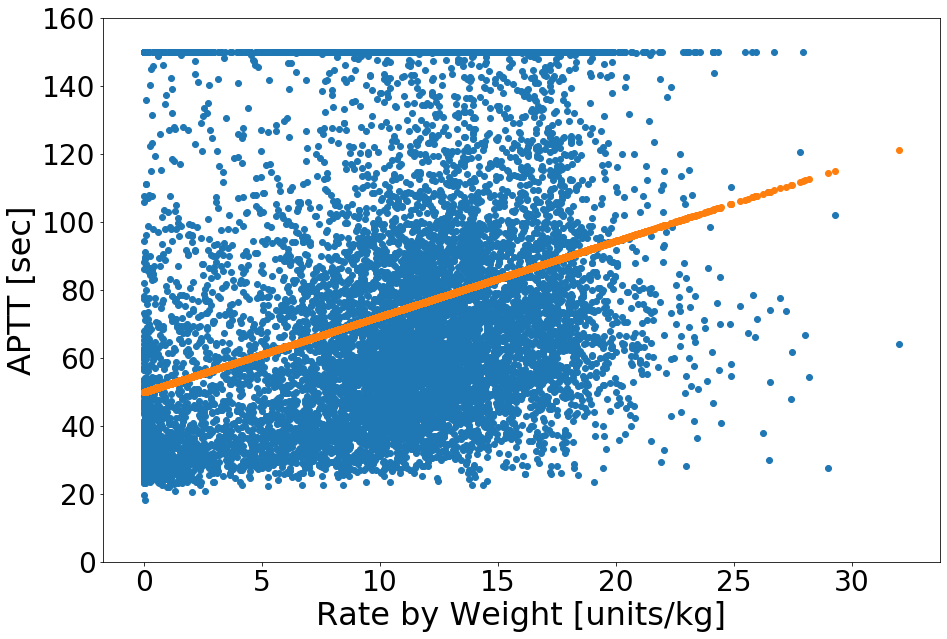

In [19]:
# Define x & y:
x = np.array([final_df['hep_concentration']]).reshape(-1,1)
y = np.array([final_df['PTT']]).reshape(-1,1)

# Remove Outliers:
temp = np.empty([])

for i in range(len(x)):
    if x[i] > 200:
        temp = np.append(temp,i) 
        
x = np.delete(x,temp).reshape(-1,1)
y = np.delete(y,temp).reshape(-1,1)

# Split Data into Train-/Test-Set:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

# Train the Linear Regression Model:
lin_reg = LinearRegression().fit(x_train, y_train)

# Plot the Results:
plt.figure(figsize=(15,10))
plt.xlabel('Rate by Weight [units/kg]', fontsize=32)
plt.ylabel('APTT [sec]', fontsize=32)
plt.ylim(0,160)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.scatter(x_train, y_train)
plt.scatter(x_train, lin_reg.predict(x_train))

# Evaluate the model:
print("EXAMPLE Lin.Reg. R2-Score: ", round(r2_score(y_test, lin_reg.predict(x_test)), 4))

### 3rd Pharmacokinetic Model - 120min Half-Life Time - Poly.Reg. (Degree 2) Example

C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  if sys.path[0] == '':
C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  del sys.path[0]


EXAMPLE Poly.Reg. (Degree 2) R2-Score:  0.1058


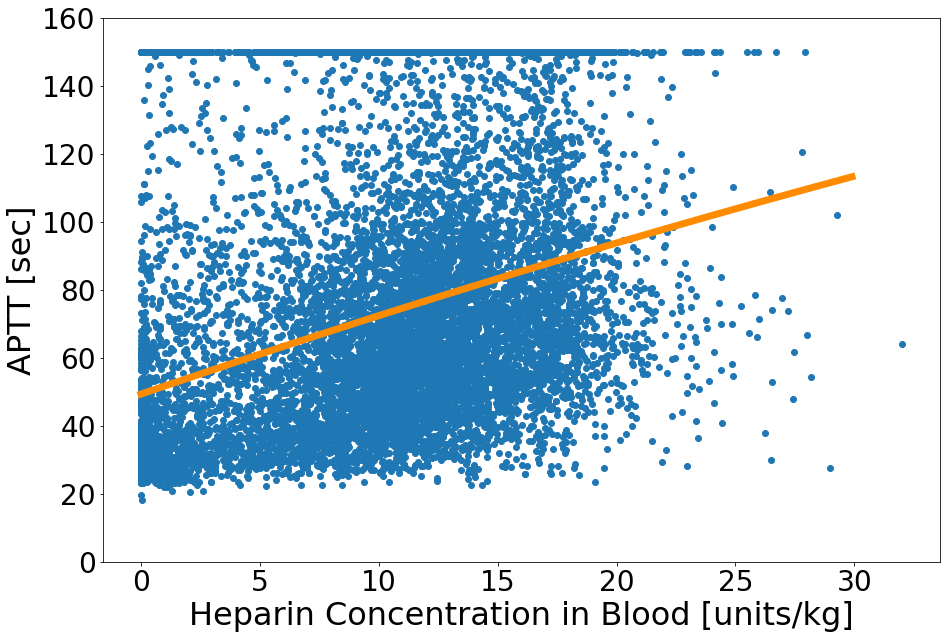

In [18]:
# Define x & y:
x = np.array([final_df['hep_concentration']]).reshape(-1,1)
y = np.array([final_df['PTT']]).reshape(-1,1)

# Remove Outliers:
temp = np.empty([])

for i in range(len(x)):
    if x[i] > 200:
        temp = np.append(temp,i) 
        
x = np.delete(x,temp).reshape(-1,1)
y = np.delete(y,temp).reshape(-1,1)

# Split Data into Train-/Test-Set:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

# Transform to Polynomial Features:
poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

# Train the Linear Regression Model:
lin_reg = LinearRegression().fit(x_train_poly, y_train)
coefficient = lin_reg.coef_
intercept = lin_reg.intercept_

# Plot the Results:
x_axis = np.arange(0,30,0.1)
response = intercept + coefficient[0][1] * x_axis + coefficient[0][2] * x_axis**2

plt.figure(figsize=(15,10))
plt.xlabel('Heparin Concentration in Blood [units/kg]', fontsize=32)
plt.ylabel('APTT [sec]', fontsize=32)
plt.ylim(0,160)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.scatter(x_train, y_train)
plt.plot(x_axis, response, c='darkorange', linewidth=7)

# Evaluate the model:
print("EXAMPLE Poly.Reg. (Degree 2) R2-Score: ", round(r2_score(y_test, lin_reg.predict(x_test_poly)), 4))